# Analysis of Monthly Mean Meteorologic Future Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. 

Variables include:
- Precipitation
- Temperature

In [6]:
from loca import print_date
print_date()

Last executed: 2019-03-18 03:26:30.264434 by jvano on r6i6n30


# Imports and Options

In [7]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_monthly_cmip_met_datasets, resample_monthly_data
from loca.utils import calc_change

# models = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC5', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M']
# models = ['ACCESS1-0', 'CanESM2']
# models = ['ACCESS1-0', 'CanESM2', 'CCSM4', 'CNRM-CM5', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']

# models = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'CMCC-CMS', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC5', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M']
# models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']


met_vars = ['pcp', 't_mean']


# CACHED:

# models = ['bcc-csm1-1']
# models = ['ACCESS1-0', 'CanESM2']
# models = ['MIROC5', 'MRI-CGCM3','bcc-csm1-1-m']
models = ['CCSM4', 'CESM1-BGC', 'CESM1-CAM5','CMCC-CM', 'GISS-E2-R', 'HadGEM2-CC']
# models = ['HadGEM2-ES']
# models = ['IPSL-CM5A-MR'] # worked second timePermissionError: [Errno 13] Permission denied: b'/glade/scratch/jvano/temp/monthly_cmip_met_hist.bcsd_IPSL-CM5A-MR.nc'
# models = ['inmcm4'] #worked second timePermissionError: [Errno 13] Permission denied: b'/glade/scratch/jvano/temp/monthly_cmip_met_hist.bcsd_inmcm4.nc'
# models = ['MIROC-ESM', 'MIROC-ESM-CHEM']  # got made, I think (had permission efforts)
# models = ['MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M']
#models = ['GFDL-ESM2G']


# NOT YET CASHED:

# ISSUES (from hydro, might not be for met data - though only going to work with models that have all data for now):
# models = ['CNRM-CM5']  # problem with lon
# models = ['ACCESS1-3'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/access1-3_rcp85_r*/*nc
# models = ['CMCC-CMS'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/cmcc-cms_rcp85_r*/*nc
# models = ['CSIRO-Mk3-6-0'] # ValueError: cannot reindex or align along dimension 'lon' because the index has duplicate values
# models = ['EC-EARTH'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/ec-earth_rcp85_r
# models = ['FGOALS-g2'] # ValueError: cannot reindex or align along dimension 'lon' because the index has duplicate values
# models = ['GFDL-ESM2M']  #ValueError: cannot reindex or align along dimension 'lon' because the index has duplicate values
# models = ['GFDL-CM3'] # cannot reindex or align along dimension 'lon' because the index has duplicate values
# models = ['GISS-E2-H'] # /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/giss-e2-h_rcp85_r*/*nc
# models = ['HadGEM2-AO'] # ValueError: zero-size array to reduction operation minimum which has no identity
# models = ['IPSL-CM5A-LR'] # no files to open: /glade/p/ral/hap/common_data/BCSD/BCSD_mon_VIC_nc/ipsl-cm5a-lr_rcp85_r*/*nc

#OTHER ERRORS:
# when rang IPSL-CM5A-MR, got error - but restarted kernel and it ran ok # KilledWorker: ('open_dataset-400ff45c9031d93361ea0737b1a2666dbounds_latitude-b94c7aafe69164f36759f70bbaf6b6eb', 'tcp://10.148.0.193:37752')
# IndexError: too many indices for array
# worked second timePermissionError: [Errno 13] Permission denied: b'/glade/scratch/jvano/temp/monthly_cmip_met_hist.bcsd_IPSL-CM5A-MR.nc' - also was able to rerun (with several models)

# PermissionError: [Errno 13] Permission denied: b'/glade/scratch/jvano/temp/monthly_cmip_met_hist.bcsd_bcc-csm1-1.nc'


# LISTS:
# models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3'] #JAV: CNRM_CM5 has an issue

# ALL:
# models = ['ACCESS1-0', 'ACCESS1-3', 'bcc-csm1-1', 'bcc-csm1-1-m', 'CanESM2', 'CCSM4', 'CESM1-BGC', 'CESM1-CAM5', 'CMCC-CM', 'CMCC-CMS', 'CNRM-CM5', 'CSIRO-Mk3-6-0', 'EC-EARTH', 'FGOALS-g2', 'GFDL-CM3', 'GFDL-ESM2G', 'GFDL-ESM2M', 'GISS-E2-H', 'GISS-E2-R', 'HadGEM2-AO', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-LR', 'IPSL-CM5A-MR', 'MIROC5', 'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'MRI-CGCM3', 'NorESM1-M']


In [8]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
# client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client

Client Scheduler: tcp://10.148.10.13:47288 Dashboard: proxy/8787/status,Cluster Workers: 72 Cores: 288 Memory: 360.00 GB


# Load Data

In [24]:
hist_data = load_monthly_cmip_met_datasets('historical', models=models, autoclose=True, parallel=True)
rcp4_data = load_monthly_cmip_met_datasets('rcp45', models=models, autoclose=True, parallel=True)
rcp8_data = load_monthly_cmip_met_datasets('rcp85', models=models, autoclose=True, parallel=True)

load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset
load_monthly_cmip_met_datasets
load_monthly_loca_meteorology
load_daily_loca_meteorology
load_monthly_bcsd_meteorology
load_bcsd_dataset


In [25]:
write_cache = False

if write_cache:
    for key, ds in hist_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_hist.{key}_{gcm}.nc'))
    for key, ds in rcp4_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_rcp4.{key}_{gcm}.nc'))
    for key, ds in rcp8_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_rcp8.{key}_{gcm}.nc'))

In [5]:
#rcp8_data.items()
hist_data.items()

dict_items([('loca', <xarray.Dataset>
Dimensions:  (gcm: 21, lat: 224, lon: 464, time: 672)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2005-12-01
  * lon      (lon) float64 -124.9 -124.8 -124.7 -124.6 ... -67.31 -67.19 -67.06
  * lat      (lat) float64 25.06 25.19 25.31 25.44 ... 52.56 52.69 52.81 52.94
  * gcm      (gcm) <U14 'ACCESS1-0' 'CCSM4' ... 'bcc-csm1-1' 'inmcm4'
Data variables:
    pcp      (gcm, time, lat, lon) float64 dask.array<shape=(21, 672, 224, 464), chunksize=(1, 72, 224, 464)>
    t_max    (gcm, time, lat, lon) float32 dask.array<shape=(21, 672, 224, 464), chunksize=(1, 72, 224, 464)>
    t_min    (gcm, time, lat, lon) float32 dask.array<shape=(21, 672, 224, 464), chunksize=(1, 72, 224, 464)>
    t_mean   (gcm, time, lat, lon) float32 dask.array<shape=(21, 672, 224, 464), chunksize=(1, 72, 224, 464)>), ('bcsd', <xarray.Dataset>
Dimensions:           (bound: 2, gcm: 21, lat: 222, lon: 462, time: 672)
Coordinates:
  * time              (t

In [9]:
read_cache = True
hist_data = {}
rcp4_data = {}
rcp8_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
        rcp4_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data[key] = xr.open_mfdataset(
            os.path.join(os.environ['TMPDIR'], f'monthly_cmip_met_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})

In [10]:
hist_epoch = slice('1969-01-01', '1999-12-31')
futr_epoch = slice('2069-01-01', '2099-12-31')

mask = hist_data['bcsd']['t_mean'].isel(gcm=0, time=0).squeeze().notnull()

# TODO: these means should be weighted by days per month
hist_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data.items())
rpc4_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data.items())
rpc8_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data.items())

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

In [20]:
kwargs = {'pcp': {'vmin': 0, 'vmax': 2500},
          't_mean': {'vmin': -10, 'vmax': 20},}
units = {'pcp': 'mm', 't_mean': 'C'}

subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]


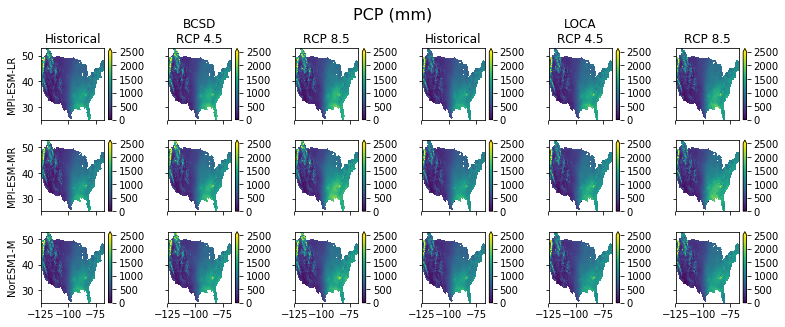

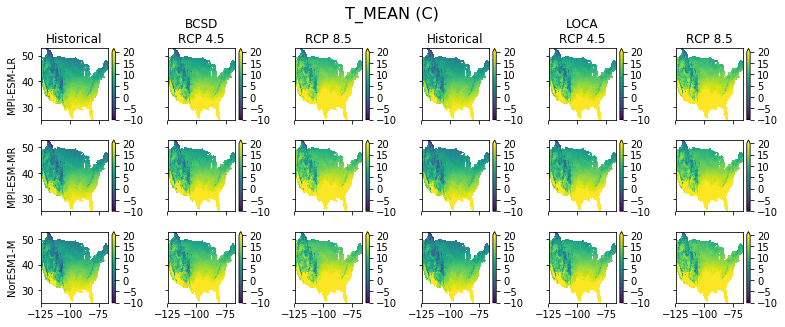

In [21]:

# models = ['HadGEM2-ES', 'IPSL-CM5A-MR', 'inmcm4', 'MIROC-ESM', 'MIROC-ESM-CHEM']

for var in met_vars:
    
    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(11, 1.5*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):           
            for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    if '4.5' in title:
                        title = dset.upper() + '\n' + title
                    ax.set_title(title)
                
                try:
                    da = ds_dict[dset][var].sel(gcm=model)
                except KeyError:
                    da = ds_dict[dset][var].sel(gcm=model.lower())
                da.plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
                
    fig.suptitle(var.upper() + ' (%s)' % units[var], fontsize=16, y=1)
    fig.tight_layout()
    unit_str = units[var]
#     fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/{var}_{unit_str}_monthly_future_met.png', dpi=300, bbox_inches='tight')


In [11]:
from loca.utils import calc_change

/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '
/glade/u/home/jvano/miniconda/envs/loca/lib/python3.6/site-packages/matplotlib/tight_layout.py:209: UserWarning: tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('tight_layout cannot make axes height small enough '


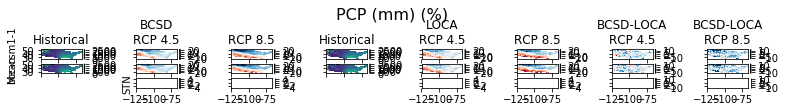

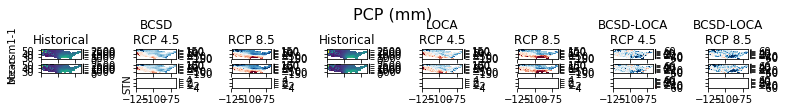

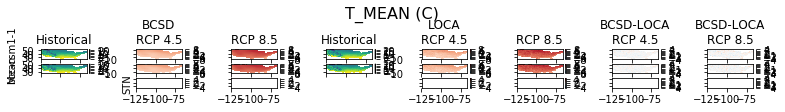

In [12]:

diff_kws = {False: {'pcp': {'vmin': -150, 'vmax': 150, 'cmap': 'RdBu'}, 't_mean': {'vmin': -8, 'vmax': 8, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}

for pct in [True, False]:
    for var in met_vars:
        cache = {}
        if var not in diff_kws[pct]:
            continue
        
        fig, axes = plt.subplots(ncols=2*len(subcols) + 2, nrows=len(models) + 2, sharex=True, sharey=True, figsize=(11, 1.5*len(models)))

        for row, model in enumerate(models):
            for i, dset in enumerate(['bcsd', 'loca']):
                for col, (title, ds_dict) in enumerate(subcols, i*len(subcols)):
                    ax = axes[row, col]

                    if col == 0:
                        ax.set_ylabel(model)
                    if row == 0:
                        if '4.5' in title:
                            title = dset.upper() + '\n' + title
                        ax.set_title(title)                    
                    if 'RCP' in title:
                        da = calc_change(hist_means[dset][var].sel(gcm=model), ds_dict[dset][var].sel(gcm=model), pct=pct)
                        da.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                    else:
                        da = hist_means[dset][var].sel(gcm=model)
                        da.plot.pcolormesh(ax=ax, add_labels=False, **kwargs[var])
                    cache[row, col] = da

        
        for col in range(2*len(subcols)):
            da = xr.concat([cache[row, col] for row in range(len(models))], dim='gcm')
            
            skws = {'vmin': -5, 'vmax': 5, 'cmap': 'RdBu'}
            
            if var == 't_mean':
                skws['cmap'] = 'RdBu_r'
            
            if col in [0, 3]:
                mkws = kwargs[var]
            else:
                mkws = diff_kws[pct][var]
            cache[len(models), col] = da.mean('gcm')
            cache[len(models), col].plot.pcolormesh(ax=axes[-2, col], add_labels=False, **mkws)
            if col not in [0, 3]:
                cache[len(models)+1, col] = (da.mean('gcm') / da.std('gcm'))
                cache[len(models)+1, col].plot.pcolormesh(ax=axes[-1, col], add_labels=False, **skws)
            else:
                fig.delaxes(axes[-1, col])
                
        for row in range(axes.shape[0]):
            for col, colnums in enumerate([[1, 4], [2, 5]], 6):
                ax = axes[row, col]
                diff = cache[row, colnums[0]] - cache[row, colnums[1]]
                diff.plot.pcolormesh(ax=axes[row, col], add_labels=False, cmap='RdBu',
                                     vmin=diff_kws[pct][var]['vmin'] / 2,
                                     vmax=diff_kws[pct][var]['vmax'] / 2)
            
                
        axes[-2, 0].set_ylabel('Mean')
        axes[-1, 1].set_ylabel('STN')
        
        axes[0, -2].set_title('BCSD-LOCA\nRCP 4.5')
        axes[0, -1].set_title('BCSD-LOCA\nRCP 8.5')
        
        title = var.upper()
        title += ' (%s)' % units[var]
        if pct:
            title += ' (%)'
            unit_str = 'pct'
        else:
            unit_str = units[var]
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
#         fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/diff_{var}_{unit_str}_monthly_future_met.png', dpi=300, bbox_inches='tight')


In [5]:
# differences between change signal in BCSD and LOCA
diff_kws = {False: {'pcp': {'vmin': -75, 'vmax': 75, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}

for pct in [True, False]:
    for var in met_vars:
        
        if var not in diff_kws[pct]:
            continue

        fig, axes = plt.subplots(ncols=2, nrows=len(models), sharex=True, sharey=True, figsize=(8, 1.5*len(models)))

        for row, model in enumerate(models):
            for col, (title, ds_dict) in enumerate(subcols[1:]):

                ax = axes[row, col]

                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)                    

                bcsd_diff = calc_change(ds_dict['bcsd'][var].sel(gcm=model),  hist_means['bcsd'][var].sel(gcm=model), pct=pct)
                loca_diff = calc_change(ds_dict['loca'][var].sel(gcm=model),  hist_means['loca'][var].sel(gcm=model), pct=pct)

                (bcsd_diff - loca_diff).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
        
        if pct:
            title = var.upper() + " - Difference (%) in Change Signal (BCSD - LOCA)"
            unit_str = 'pct'
        else:
            unit_str = units[var]
            title = var.upper() + " - Difference (%s) in Change Signal (BCSD - LOCA)" % unit_str
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
#         fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/diff2_{var}_{unit_str}_monthly_future_met.png', dpi=300, bbox_inches='tight')
        

NameError: name 'met_vars' is not defined

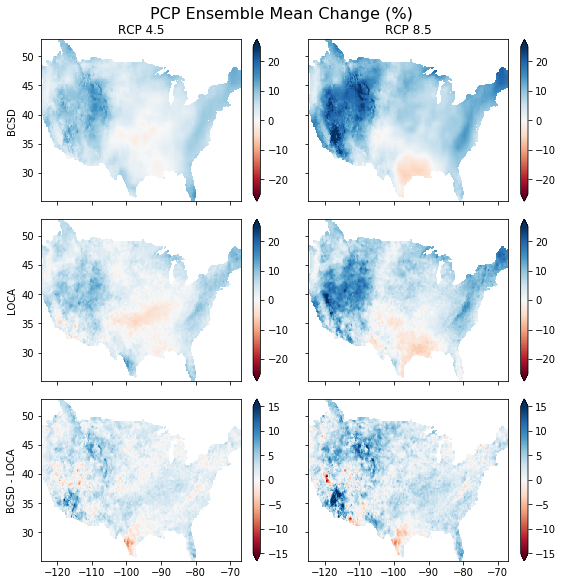

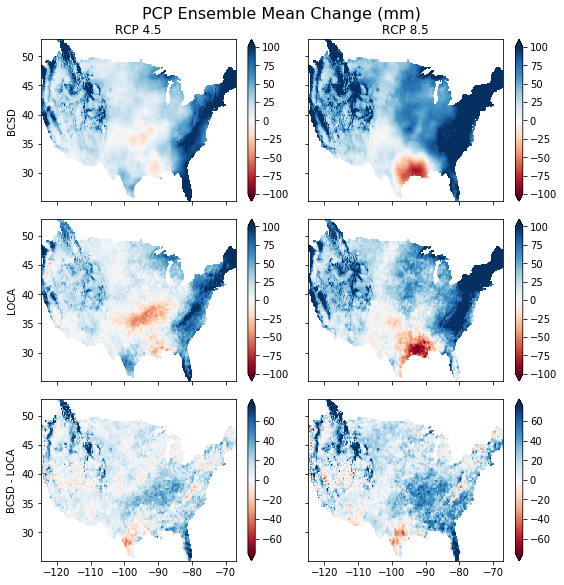

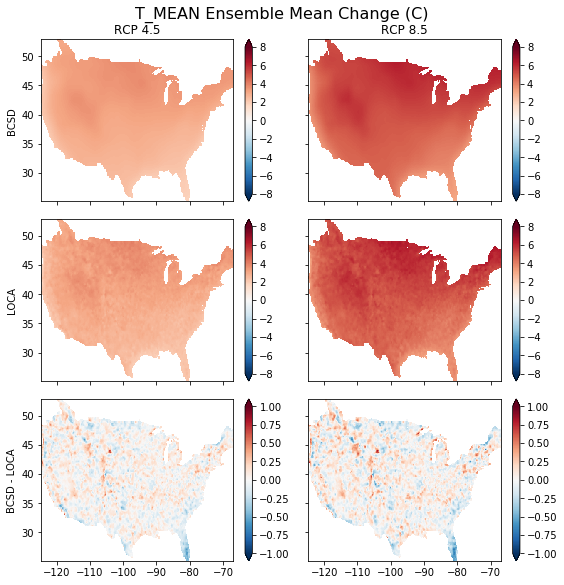

In [12]:
cache = {}

diff_kws = {False: {'pcp': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu'}, 't_mean': {'vmin': -8, 'vmax': 8, 'cmap': 'RdBu_r'}},
            True: {'pcp': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu'}}}

diff2_kws = {False: {'pcp': {'vmin': -75, 'vmax': 75, 'cmap': 'RdBu'}, 't_mean': {'vmin': -1, 'vmax': 1, 'cmap': 'RdBu_r'}},
             True: {'pcp': {'vmin': -15, 'vmax': 15, 'cmap': 'RdBu'}}}

for pct in [True, False]:

    for var in met_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(8, 8))

        for col, (title, dsets) in enumerate(subcols[1:]):

            for row, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, extend='both', **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(title)
                if col == 0:
                    ax.set_ylabel(dset.upper())

            diff = cache[(row - 1, col)] - cache[(row, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, extend='both', **diff2_kws[pct][var])
        axes[-1, 0].set_ylabel('BCSD - LOCA')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = units[var]
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout() 
#         fig.savefig(f'/glade/u/home/jhamman/workdir/loca_figs/diff3_{var}_{unit_str}_monthly_future_met.png', dpi=300, bbox_inches='tight')
        
    

In [13]:
plt.close('all')